# Individual differences in the GCM

In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np

import bayesflow as bf
import json

Here we will allow for individual differences between participants. The
simplest way to start is to estimate the parameter values for each
participant independently. Hence we estimate two parameters per
participant. It may seem that we have to extend the model. However,
since we assume that the participants are independent, we may as well
*simplify* the model to assume data from a single participant only, and
apply it to each participant in independently.

### Data

We use the category learning data from the “Condensation B” condition
from Kruschke (1993) as reported by Lee & Wagenmakers (2013).

In [3]:
with open(os.path.join("data", "KruschkeData.json")) as f:
    data = json.load(f)

data.keys()

dict_keys(['a', 'd1', 'd2', 'n', 'nstim', 'nsubj', 'y'])

### Simulator

We will reuse the prior and simulator from the first example of the GCM.
The only difference is that we will remove the `nsubj` argument, and in
so doing simplifying the simulation so that every data set contains data
from a single participant.

In [4]:
def prior():
    return dict(
        c = np.random.exponential(scale=1),
        w = np.random.uniform(low=0, high=1)
    )

def likelihood(c, w, n=data['n'], nstim=data['nstim'], d1=np.array(data['d1']), d2=np.array(data['d2']), a=np.array(data['a'])):
    b = 0.5

    s = np.exp( - c * (w * d1 + (1-w) * d2))

    r = np.zeros(nstim)

    for i in range(nstim):
        isA = a == 1
        isB = a != 1

        numerator = b * np.sum(s[i,isA])
        denominator = numerator + (1-b) * np.sum(s[i,isB])

        r[i] = numerator / denominator

    y = np.random.binomial(n=n, p=r, size=nstim)

    return dict(y=y)

simulator = bf.make_simulator([prior, likelihood])

### Approximator

We will use `BasicWorkflow` again. The task is to predict the posterior
distribution of the parameters $c$ and $w$, given the observed data $y$.
Since $y$ is of fixed size, we might not need a summary network.

In [8]:
adapter = (bf.Adapter()
    .constrain("c", lower=0)
    .constrain("w", lower=0, upper=1)
    .concatenate(["c", "w"], into="inference_variables")
    .rename("y", "inference_conditions")
)

In [ ]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow(),
)

### Training

In [ ]:
history=workflow.fit_online(epochs=50, batch_size=256)

### Validation

In [11]:
test_data = simulator.sample(1000)

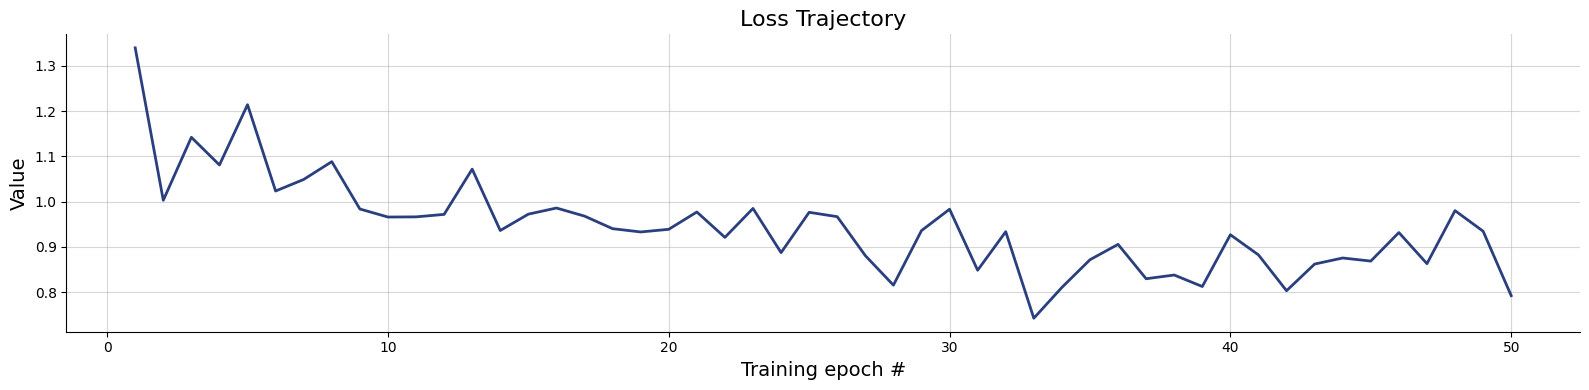

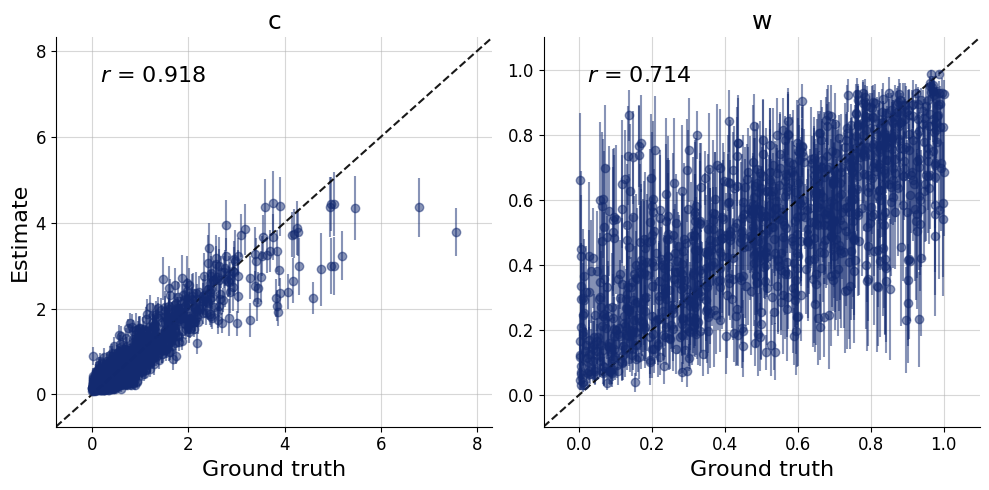

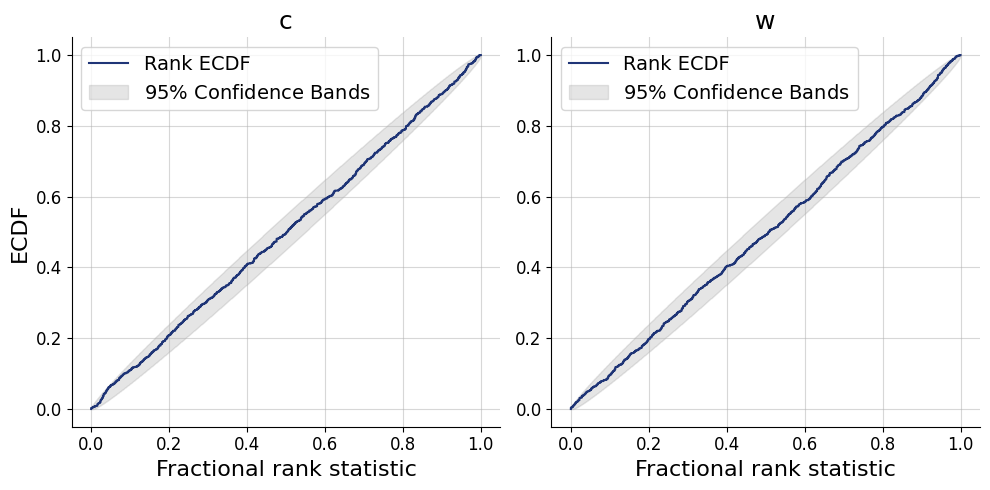

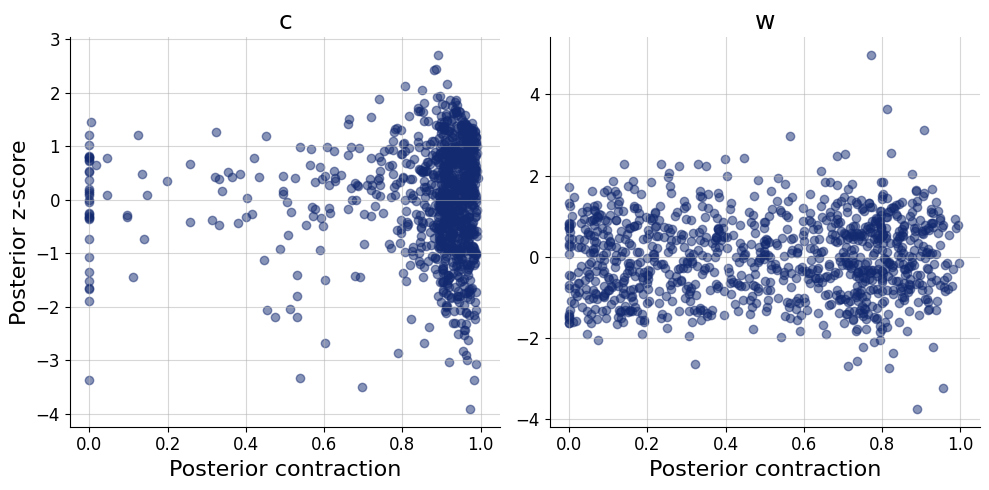

In [12]:
figs = workflow.plot_default_diagnostics(test_data=test_data, num_samples=500)

### Inference

Now, we can use the approximator to obtain our posterior distributions
of $c$ and $w$ for all 40 participants in the data set.

In [14]:
inference_data = dict(y = np.array(data['y']).transpose())

inference_data['y'].shape

(40, 8)

In [15]:
posterior_samples = workflow.sample(num_samples=2000, conditions=inference_data)

In [31]:
posterior_means = {par: np.mean(samples, axis=1) for par, samples in posterior_samples.items()}

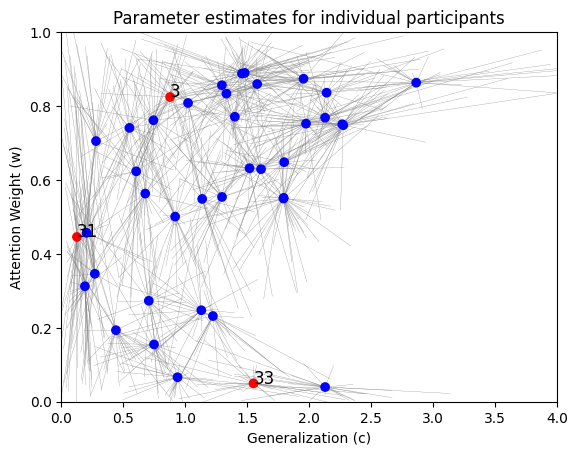

In [34]:
highlight = [2, 30, 32]
cols = ["blue" if i not in highlight else "red" for i in range(data['nsubj'])]

plt.scatter(
    posterior_means['c'],
    posterior_means['w'], 
    color=cols, zorder=2)
for p in range(data['nsubj']):
    if p in highlight:
        plt.text(
            posterior_means['c'][p], 
            posterior_means['w'][p], 
            str(p+1), zorder=3, fontsize=12)
    for l in range(25):
        x = [posterior_means['c'][p], 
             posterior_samples['c'][p,l]
            ]
        y = [posterior_means['w'][p], 
             posterior_samples['w'][p,l]
            ]
        plt.plot(x, y, color="gray", linewidth=0.2, zorder=0)

plt.xlim(0, 4)
plt.xlabel("Generalization (c)")
plt.ylim(0, 1)
plt.ylabel("Attention Weight (w)")
f=plt.title("Parameter estimates for individual participants")

Kruschke, J. K. (1993). Human category learning: Implications for
backpropagation models. *Connection Science*, *5*(1), 3–36.

Lee, M. D., & Wagenmakers, E.-J. (2013). *Bayesian Cognitive Modeling: A
Practical Course*. Cambridge University Press.